<a href="https://colab.research.google.com/github/TEJAS-Arya/DEEP_MAGIC/blob/main/hangman_api_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved.
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [38]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import collections


In [40]:
vowels = ['a', 'e', 'i', 'o', 'u']
# ratio of vowels to length of word
def vowel_count(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count = count+1.0
    return count/len(clean_word)
f = open("words_250000_train.txt", "r")
df = []
for x in f:
  df.append(x)
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")
l=[]
for words in df:
    l.append(vowel_count(words))
l = pd.Series(l)
l.describe()

,0
count,227300.000000
mean,0.386889
std,0.095527
min,0.000000
25%,0.333333
50%,0.384615
75%,0.444444
max,1.000000


(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

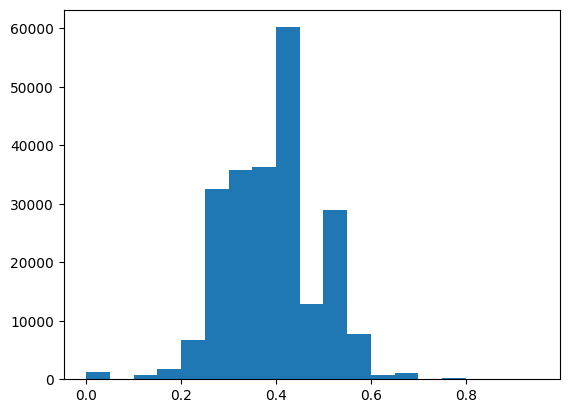

In [41]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = l, bins = bins)

In [42]:
max_length = 0
for words in df:
    if(len(words)>max_length):
        max_length = len(words)
n_word_dictionary = {i:[] for i in range(3, 30)}
count = 3
while count<=max_length:
    for words in df:
        if(len(words)>=count):
            for i in range(len(words)-count+1):
                #if words[i:i+count-1] not in n_word_dictionary[count]:
                n_word_dictionary[count].append(words[i:i+count])
    count = count+1
# function to find number of times a letter come in whole dictionary, keeping count of letter 1 if it comes in a word else 0
def func(new_dictionary):
    dictx = collections.Counter()
    for words in new_dictionary:
        temp = collections.Counter(words)
        for i in temp:
            temp[i] = 1
            dictx = dictx + temp
    return dictx
# function to generate a list of words which are substring in the original dictionary and of same length as clean word
def func2(n_word_dictionary, clean_word):
    new_dictionary = []
    l = len(clean_word)
    for dict_word in n_word_dictionary[l]:
        if re.match(clean_word,dict_word):
            new_dictionary.append(dict_word)
    return new_dictionary
HANGMAN_URL = "https://www.trexsim.com/trexsim/hangman"

class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

        self.current_dictionary = []





    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")

        # find length of passed word
        len_word = len(clean_word)

        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []

        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue

            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)

        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary

        '''
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)

        c = collections.Counter(full_dict_string)
        '''

        c = func(new_dictionary)

        sorted_letter_count = c.most_common()

        guess_letter = '!'

        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                if letter in vowels and vowel_count(clean_word)>0.55:
                    self.guessed_letters.append(letter)
                    continue
                guess_letter = letter
                break

        if guess_letter == '!':
            new_dictionary = func2(n_word_dictionary, clean_word)
            c = func(new_dictionary)
            sorted_letter_count = c.most_common()
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break


        if guess_letter == '!':
            x = int(len(clean_word)/2)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break


        if guess_letter == '!':
            x = int(len(clean_word)/3)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break


        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break

        return guess_letter







    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        try:
            # response = self.session.request(
            response = requests.request(
                method or "GET",
                HANGMAN_URL + path,
                timeout=self.timeout,
                params=args,
                data=post_args)
        except requests.HTTPError as e:
            response = json.loads(e.read())
            raise HangmanAPIError(response)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object.
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [19]:
api = HangmanAPI(access_token="c85cd9a9ee623d95156e8b78802501", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [32]:


# Set the target practice success rate
target_success_rate = 0.60

# Continue the loop until the practice success rate reaches the target
while practice_success_rate < target_success_rate and total_practice_runs < 100000:
    # Start a new game
    api.start_game(practice=1, verbose=True)

    # Get updated game stats
    [total_practice_runs, total_recorded_runs, total_recorded_successes, total_practice_successes] = api.my_status()

    # Calculate the practice success rate
    practice_success_rate = total_practice_successes / total_practice_runs

    # Print the current status
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

# Print a message when the loop exits
if practice_success_rate >= target_success_rate:
    print("Achieved the target practice success rate of %.3f!" % target_success_rate)
else:
    print("Exceeded the maximum allowed practice games (100,000) without reaching the target success rate.")

Successfully start a new game! Game ID: 004a8e5bae38. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '004a8e5bae38', 'status': 'failed', 'tries_remains': 0, 'word': '_ _ _ _ _ _ _ _ _ '}
Failed game: 004a8e5bae38. Because of: # of tries exceeded!
run 283 practi

KeyboardInterrupt: 

best practice success rate achieved so far=0.504

In [28]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: 19211c32dcd5. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: None
Sever response: {'game_id': '19211c32dcd5', 'status': 'failed', 'tries_remains': 0, 'word': '_ _ _ _ _ _ _ _ _ '}
Failed game: 19211c32dcd5. Because of: # of tries exceeded!
run 228 practi

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [43]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)

    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game


HangmanAPIError: {'error': 'Your account has been deactivated!'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [45]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.000
